## Web Page Identification via Traffic Pattern Analysis

This section of the notebook uses the files `brave_mapping.json`, `chrome_mapping.json`, `edge_mapping.json`, `firefox_mapping.json`, and `torbrowser_mapping.json`. Either use our version of these files or generate them yourself with the commands `python make_json_sizelist.py BRAVE/ brave_mapping.json`, `python make_json_sizelist CHROME/ chrome_mapping.json`, etc...

In [36]:
import os
print(os.listdir('.'))

['edge_mapping.json', 'firefox_mapping_NORM.json', 'firefox_packet_distributions.json', 'brave_mapping.json', '.local', 'firefox_mapping.json', 'torbrowser_mapping.json', '.config', 'Page Identification Revised.ipynb', 'torbrowser_mapping_NORM.json', 'chrome_mapping.json', '.ipython', '.cache', '.ipynb_checkpoints', 'Webpage Identification.ipynb', '.conda', '.yarn', 'work', '.bashrc', '.bash_logout', '.profile']


In [37]:
import json
import numpy as np
from matplotlib import pyplot as plt

In [38]:
GRAPH_FILES = ["brave_mapping.json", "chrome_mapping.json", "edge_mapping.json", "firefox_mapping.json", "torbrowser_mapping.json"]

In [39]:
complete_graph = {}

for gf in GRAPH_FILES:
	f_json = open(gf, 'r')
	g_data = json.loads(f_json.read())
	f_json.close()
	
	for pageid in g_data:
		if pageid not in complete_graph:
			complete_graph[pageid] = {}
		
		complete_graph[pageid][gf] = g_data[pageid]

In [40]:
displayable_pages = []
browser_graphs = {}
for gf in GRAPH_FILES:
	browser_graphs[gf] = []

for pageid in complete_graph:
	graphThis = True
	for gf in GRAPH_FILES:
		if gf not in complete_graph[pageid]:
			graphThis = False
			break #Don't graph unless we have recordings from all browsers
	
	if not graphThis:
		continue
	
	#We are here only because this instance of pageid exists in all GRAPH_FILES
	displayable_pages.append(pageid)
	for key in GRAPH_FILES:
		browser_graphs[key].append(complete_graph[pageid][key])


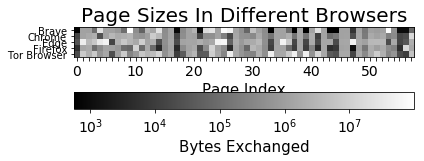

In [41]:
#Draw it!
fig, ax = plt.subplots()
heatmap = []
maxvals = []
for key in browser_graphs:
	for i in range(1):
		mv = np.log(np.array(browser_graphs[key])).max()
		heatmap.append(np.log10(np.array(browser_graphs[key])) / 1)
		maxvals.append(mv)

heatmap = np.array(heatmap)

im = plt.imshow(heatmap, cmap='gray')
cbar = ax.figure.colorbar(im, orientation='horizontal')
cbar.ax.set_xticklabels(['$10^{3}$','$10^{4}$','$10^{5}$','$10^{6}$','$10^{7}$'], fontsize=14)
cbar.ax.set_xlabel('Bytes Exchanged', fontsize=15)

plt.title('Page Sizes In Different Browsers', fontsize=20)
plt.xlabel('Page Index', fontsize=15)

ax.set_yticks(np.array(range(len(GRAPH_FILES))) * 1)
ax.set_yticklabels(["Brave", "Chrome", "Edge", "Firefox", "Tor Browser"])

ax.set_xticks(range(58))
ax.set_xticklabels([0,'','','','','','','','','',10,'','','','','','','','','',20,'','','','','','','','','',30,'','','','','','','','','',40,'','','','','','','','','',50,'','','','','','',''], fontsize=14)

fig.tight_layout()
plt.show()

This section of the notebook uses the file `firefox_packet_distributions.json`. Either use our version or generate it yourself with the command `python make_json_distribution_list.py FIREFOX/ firefox_packet_distributions.json`.

In [42]:
GRAPH_FILE = "firefox_packet_distributions.json"

In [43]:
f_json = open(GRAPH_FILE, 'r')
complete_graph = json.loads(f_json.read())
f_json.close()

In [44]:
waterfall = []
#Organizing data for drawing
for pageid in complete_graph:
    waterfall.append(np.array(complete_graph[pageid]).clip(0,2)[0:1500])

In [45]:
waterfall = np.array(waterfall).transpose()

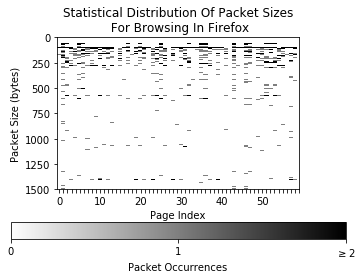

In [46]:
#Draw it!
fig, ax = plt.subplots()
im = plt.imshow(waterfall, cmap='gist_yarg', aspect=0.025)

cbar = ax.figure.colorbar(im, orientation='horizontal', ticks=[0,1,2])
cbar.ax.set_xticklabels(['0', '1', '$\geq 2$'])
cbar.ax.set_xlabel('Packet Occurrences')

plt.title('Statistical Distribution Of Packet Sizes\n For Browsing In Firefox')
plt.xlabel('Page Index')
plt.ylabel('Packet Size (bytes)')

ax.set_xticks(range(60))
ax.set_xticklabels(['0']+(['']*9)+['10']+(['']*9)+['20']+(['']*9)+['30']+(['']*9)+['40']+(['']*9)+['50']+(['']*9)+['60'])

plt.show()

## Measuring Quality of Side-Channel Information from Tor Browser Traffic

This section of the notebook uses the files `firefox_mapping_NORM.json` and `torbrowser_mapping_NORM.json`. Either use our own or generate them yourself with the commands `python normalize_json_sizelist.py firefox_mapping.json firefox_mapping_NORM.json` and `python normalize_json_sizelist.py torbrowser_mapping.json torbrowser_mapping_NORM.json`.

In [47]:
class AutoSortedMap:
	def __init__(self):
		self.keys = []
		self.values = []
	
	def add_item(self, key, value):
		if len(self.keys) == 0:
			self.keys.append(key)
			self.values.append(value)
			return
		
		for i in range(0, len(self.values)):
			if self.values[i] > value:
				self.values.insert(i, value)
				self.keys.insert(i, key)
				return
			
		self.values.append(value)
		self.keys.append(key)
		
	
	def pretty_print(self):
		for i in range(0, len(self.values)):
			print("{} -- {}".format(self.values[i], self.keys[i]))
	
	def calculate_insertion_index(self, value):
		for i in range(0, len(self.values)):
			if self.values[i] > value:
				return i
		
		return len(self.values)
	
	def measure_insertion_distance(self, key, value):
		#What index does this key classify itself as?
		idx = self.keys.index(key)
		
		#What does value nearest-neighbor classfy itself as?
		diff_array = list(abs(np.array(self.values) - value))
		smallest = min(diff_array)
		predicted_class_index = diff_array.index(smallest)
		
		return abs(idx - predicted_class_index)
	
	def get_keys_count(self):
		return len(self.keys)

In [48]:
GRAPH_FILES = ["firefox_mapping_NORM.json", "torbrowser_mapping_NORM.json"]
TRAIN_KEY = "firefox_mapping_NORM.json"
TEST_KEY = "torbrowser_mapping_NORM.json"

In [49]:
complete_graph = {}
for gf in GRAPH_FILES:
	f_json = open(gf, 'r')
	g_data = json.loads(f_json.read())
	f_json.close()
	
	for pageid in g_data:
		if pageid not in complete_graph:
			complete_graph[pageid] = {}
		
		complete_graph[pageid][gf] = g_data[pageid]

In [50]:
browser_graphs = {}
for gf in GRAPH_FILES:
	browser_graphs[gf] = []

for pageid in complete_graph:
	graphThis = True
	for gf in GRAPH_FILES:
		if gf not in complete_graph[pageid]:
			graphThis = False
			break #Don't graph unless we have recordings from all browsers
	
	if not graphThis:
		continue
	
	#We are here only because this instance of pageid exists in all GRAPH_FILES
	for key in GRAPH_FILES:
		browser_graphs[key].append((complete_graph[pageid][key], pageid))

In [51]:
training_asm = AutoSortedMap()
for example in browser_graphs[TRAIN_KEY]:
    training_asm.add_item(example[1], example[0])

In [52]:
torbrowser_distances = []
for example in browser_graphs[TEST_KEY]:
    dst = training_asm.measure_insertion_distance(example[1], example[0])
    torbrowser_distances.append(dst)

In [53]:
max_dst = training_asm.get_keys_count() - 1

In [54]:
normalized_dst = np.array(torbrowser_distances) / float(max_dst)
mean_dst = np.mean(normalized_dst)
std_dst = np.std(normalized_dst)

In [55]:
print("========================")
print("+                      +")
print("+        Results       +")
print("+                      +")
print("========================")

print("")

print("Mean(DST) = {}".format(mean_dst))
print("StdDev(DST) = {}".format(std_dst))

+                      +
+        Results       +
+                      +

Mean(DST) = 0.30976037405026297
StdDev(DST) = 0.2805520038237878
